In [1]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [2]:
# Tắt các cảnh báo không cần thiết từ matplotlib
warnings.filterwarnings('ignore', category=UserWarning)

# PHẦN 1: CẤU HÌNH VÀ KẾT NỐI

MONGO_URI = "mongodb://localhost:27017/"
DATABASE_NAME = "traffic"
COLLECTION_NAME = "traffic1"
SAMPLE_SIZE = 200000
# ---------------------------

In [3]:
# --- Kết nối tới MongoDB ---
try:
    client = MongoClient(MONGO_URI, serverSelectionTimeoutMS=5000)
    client.server_info() # Dòng này sẽ báo lỗi nếu không kết nối được
    db = client[DATABASE_NAME]
    collection = db[COLLECTION_NAME]
    print(f"Kết nối thành công tới DB: '{DATABASE_NAME}', Collection: '{COLLECTION_NAME}'")
except Exception as e:
    print(f"LỖI: Không thể kết nối tới MongoDB. Vui lòng kiểm tra lại URI và đảm bảo server đang chạy.")
    print(f"Chi tiết lỗi: {e}")
    exit()

Kết nối thành công tới DB: 'traffic', Collection: 'traffic1'


In [4]:
# --- Tải dữ liệu mẫu vào Pandas DataFrame ---
print(f"\nĐang tải {SAMPLE_SIZE:,} bản ghi mẫu từ MongoDB vào Pandas...")
try:
    cursor = collection.find().limit(SAMPLE_SIZE)
    df = pd.DataFrame(list(cursor))
    if df.empty:
        print("LỖI: Collection trống hoặc không thể đọc dữ liệu.")
        exit()
    print("Tải dữ liệu thành công.")
except Exception as e:
    print(f"LỖI: Có vấn đề khi tải dữ liệu. Chi tiết: {e}")
    exit()



Đang tải 200,000 bản ghi mẫu từ MongoDB vào Pandas...
Tải dữ liệu thành công.


In [5]:
# --- Tiền xử lý dữ liệu ---
print("Đang tiền xử lý dữ liệu (chuyển đổi kiểu, xử lý null)...")
df['count_date'] = pd.to_datetime(df['count_date'])
numeric_cols = [
    'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 
    'buses_and_coaches', 'lgvs', 'all_hgvs', 'all_motor_vehicles'
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
df['day_of_week'] = df['count_date'].dt.day_name()


Đang tiền xử lý dữ liệu (chuyển đổi kiểu, xử lý null)...


In [7]:
# --- Phân tích 1: Phân bổ lưu lượng phương tiện ---
print("\n[PHÂN TÍCH 1]: Phân bổ lưu lượng phương tiện (Thống kê mô tả)")
print("---------------------------------------------------------------")
# Sử dụng describe() để có cái nhìn tổng quan: trung bình, min, max, etc.
traffic_distribution = df[['cars_and_taxis', 'lgvs', 'buses_and_coaches', 'all_motor_vehicles']].describe()
print(traffic_distribution)


[PHÂN TÍCH 1]: Phân bổ lưu lượng phương tiện (Thống kê mô tả)
---------------------------------------------------------------
       cars_and_taxis           lgvs  buses_and_coaches  all_motor_vehicles
count   200000.000000  200000.000000      200000.000000       200000.000000
mean       283.206080      57.992810           3.008980          370.652005
std        558.870918     133.167396           6.981264          757.795198
min          0.000000       0.000000           0.000000            0.000000
25%         18.000000       3.000000           0.000000           22.000000
50%         70.000000      12.000000           0.000000           87.000000
75%        274.000000      45.000000           3.000000          340.000000
max       6758.000000    1733.000000         131.000000         9110.000000


In [8]:
# --- Phân tích 2: Phân bổ các thuộc tính loại ---
print("\n[PHÂN TÍCH 2]: Phân bổ các thuộc tính loại (Categorical)")
print("----------------------------------------------------------")
# Sử dụng value_counts() để đếm số lần xuất hiện của mỗi loại
print("\n>>> Phân bổ theo Loại đường (road_type):")
print(df['road_type'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

print("\n>>> Phân bổ theo Hướng di chuyển (direction_of_travel):")
print(df['direction_of_travel'].value_counts())


[PHÂN TÍCH 2]: Phân bổ các thuộc tính loại (Categorical)
----------------------------------------------------------

>>> Phân bổ theo Loại đường (road_type):
road_type
Minor    74.25%
Major    25.75%
Name: proportion, dtype: object

>>> Phân bổ theo Hướng di chuyển (direction_of_travel):
direction_of_travel
E    50525
W    50523
N    49524
S    49428
Name: count, dtype: int64



[PHÂN TÍCH 3]: Xu hướng theo giờ (Giờ cao điểm)
--------------------------------------------------
Lưu lượng trung bình theo giờ:
    hour  all_motor_vehicles
0      7          397.634967
1      8          419.335173
2      9          342.637367
3     10          313.705748
4     11          319.551629
5     12          330.210103
6     13          337.569989
7     14          358.590724
8     15          398.547549
9     16          439.076563
10    17          439.246850
11    18          351.726825
-> Đã lưu biểu đồ vào file '1_hourly_trend.png'


C:\Users\DELL\AppData\Local\Temp\ipykernel_25500\119743071.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y='all_motor_vehicles', data=hourly_traffic, palette="viridis")


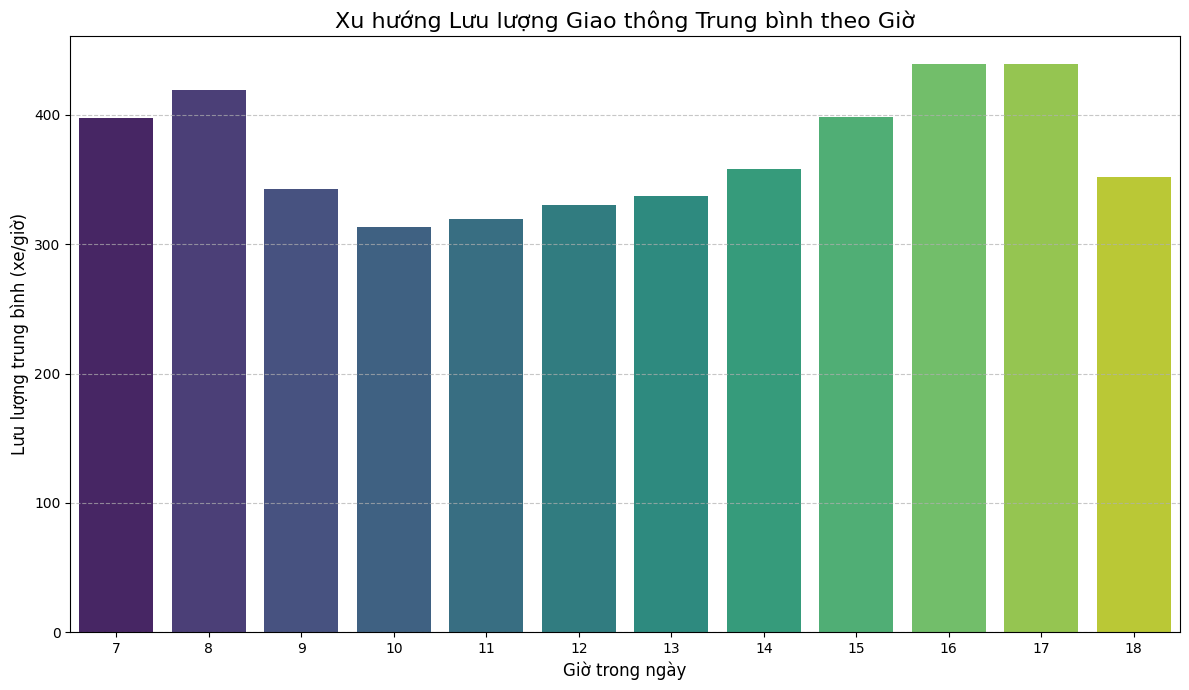

In [9]:
# --- Phân tích 3: Xu hướng theo giờ (Giờ cao điểm) ---
print("\n[PHÂN TÍCH 3]: Xu hướng theo giờ (Giờ cao điểm)")
print("--------------------------------------------------")
hourly_traffic = df.groupby('hour')['all_motor_vehicles'].mean().reset_index()
print("Lưu lượng trung bình theo giờ:")
print(hourly_traffic)
# Trực quan hóa
plt.figure(figsize=(12, 7))
sns.barplot(x='hour', y='all_motor_vehicles', data=hourly_traffic, palette="viridis")
plt.title('Xu hướng Lưu lượng Giao thông Trung bình theo Giờ', fontsize=16)
plt.xlabel('Giờ trong ngày', fontsize=12)
plt.ylabel('Lưu lượng trung bình (xe/giờ)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('1_hourly_trend.png')
print("-> Đã lưu biểu đồ vào file '1_hourly_trend.png'")


[PHÂN TÍCH 4]: Xu hướng theo ngày trong tuần
---------------------------------------------
Lưu lượng trung bình theo ngày trong tuần:
  day_of_week  all_motor_vehicles
0      Monday          348.649010
1     Tuesday          346.372983
2   Wednesday          396.290010
3    Thursday          364.892663
4      Friday          392.286811
5    Saturday                 NaN
6      Sunday                 NaN
-> Đã lưu biểu đồ vào file '2_daily_trend.png'


C:\Users\DELL\AppData\Local\Temp\ipykernel_25500\3680879328.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='all_motor_vehicles', data=daily_traffic, palette="plasma", order=day_order)


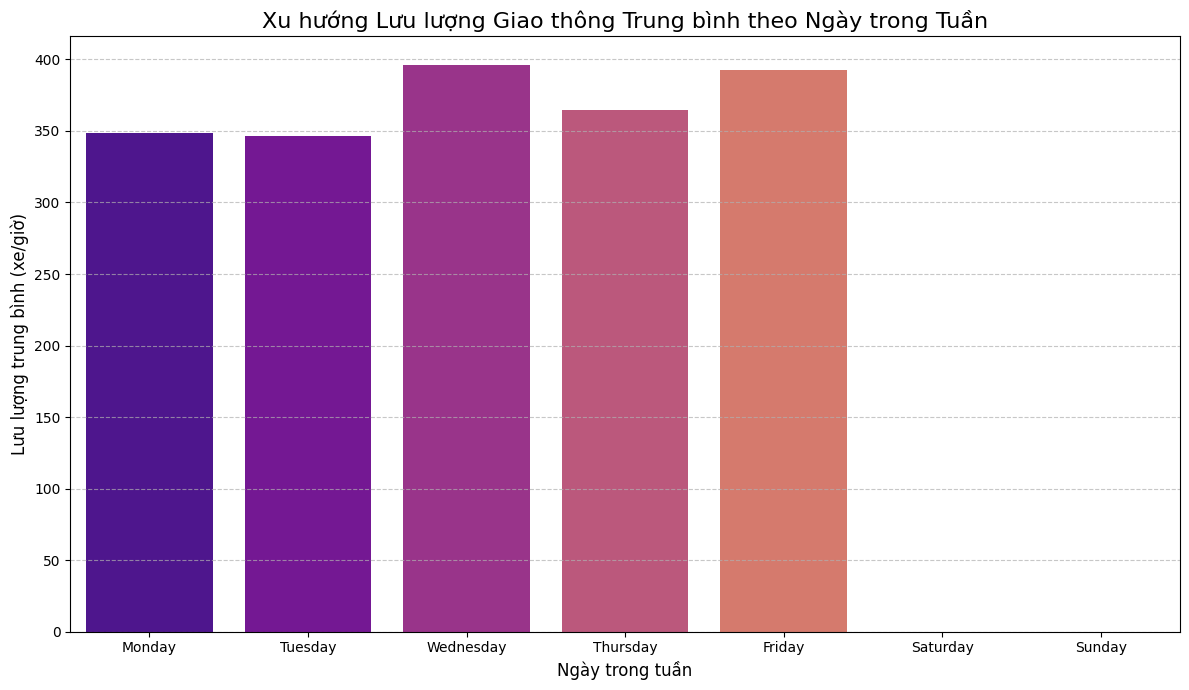

In [10]:
# --- Phân tích 4: Xu hướng theo ngày trong tuần ---
print("\n[PHÂN TÍCH 4]: Xu hướng theo ngày trong tuần")
print("---------------------------------------------")
# Sắp xếp lại thứ tự các ngày cho đúng
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_traffic = df.groupby('day_of_week')['all_motor_vehicles'].mean().reindex(day_order).reset_index()
print("Lưu lượng trung bình theo ngày trong tuần:")
print(daily_traffic)
# Trực quan hóa
plt.figure(figsize=(12, 7))
sns.barplot(x='day_of_week', y='all_motor_vehicles', data=daily_traffic, palette="plasma", order=day_order)
plt.title('Xu hướng Lưu lượng Giao thông Trung bình theo Ngày trong Tuần', fontsize=16)
plt.xlabel('Ngày trong tuần', fontsize=12)
plt.ylabel('Lưu lượng trung bình (xe/giờ)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('2_daily_trend.png')
print("-> Đã lưu biểu đồ vào file '2_daily_trend.png'")


[PHÂN TÍCH 5]: 10 Tuyến đường huyết mạch (Lưu lượng cao nhất)
-----------------------------------------------------------------
road_name
U       4648949
C       4419113
M1      2956639
M60     2317274
M25     1840920
M62     1703676
A38     1497179
A406    1484650
A12     1471608
A1      1432077
Name: all_motor_vehicles, dtype: int32
-> Đã lưu biểu đồ vào file '3_top_10_roads.png'


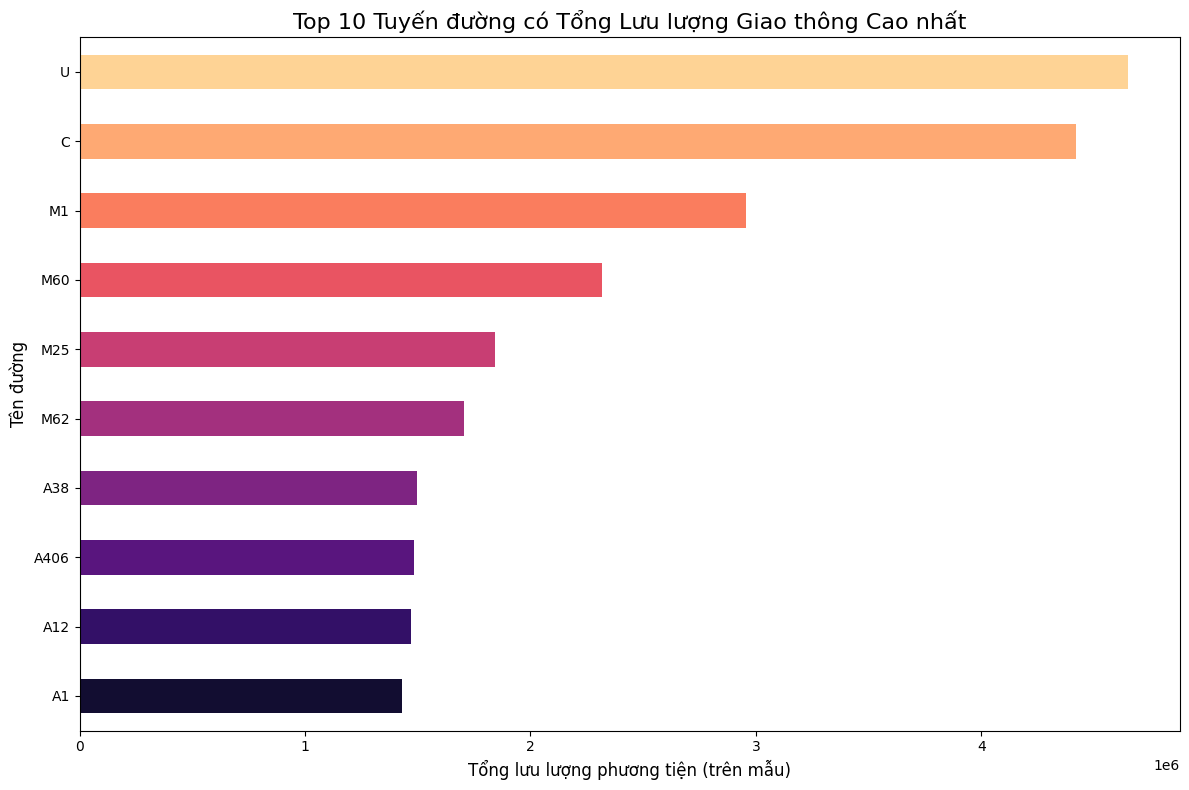

In [11]:
# --- Phân tích 5: Các tuyến đường huyết mạch ---
print("\n[PHÂN TÍCH 5]: 10 Tuyến đường huyết mạch (Lưu lượng cao nhất)")
print("-----------------------------------------------------------------")
# Nhóm theo tên đường, tính tổng lưu lượng và lấy 10 đường lớn nhất
top_10_roads = df.groupby('road_name')['all_motor_vehicles'].sum().nlargest(10)
print(top_10_roads)
# Trực quan hóa
plt.figure(figsize=(12, 8))
top_10_roads.sort_values(ascending=True).plot(kind='barh', color=sns.color_palette("magma", 10))
plt.title('Top 10 Tuyến đường có Tổng Lưu lượng Giao thông Cao nhất', fontsize=16)
plt.xlabel('Tổng lưu lượng phương tiện (trên mẫu)', fontsize=12)
plt.ylabel('Tên đường', fontsize=12)
plt.tight_layout()
plt.savefig('3_top_10_roads.png')
print("-> Đã lưu biểu đồ vào file '3_top_10_roads.png'")


[PHÂN TÍCH 6]: 10 Khu vực trọng điểm (Nhiều điểm đếm nhất)
--------------------------------------------------------------
local_authority_name
Devon              9480
Norfolk            9252
Essex              8304
Lancashire         7704
Hertfordshire      7140
Derbyshire         5508
Lincolnshire       4992
Nottinghamshire    4536
Cumbria            4056
Somerset           4044
Name: count, dtype: int64
-> Đã lưu biểu đồ vào file '4_top_10_authorities.png'


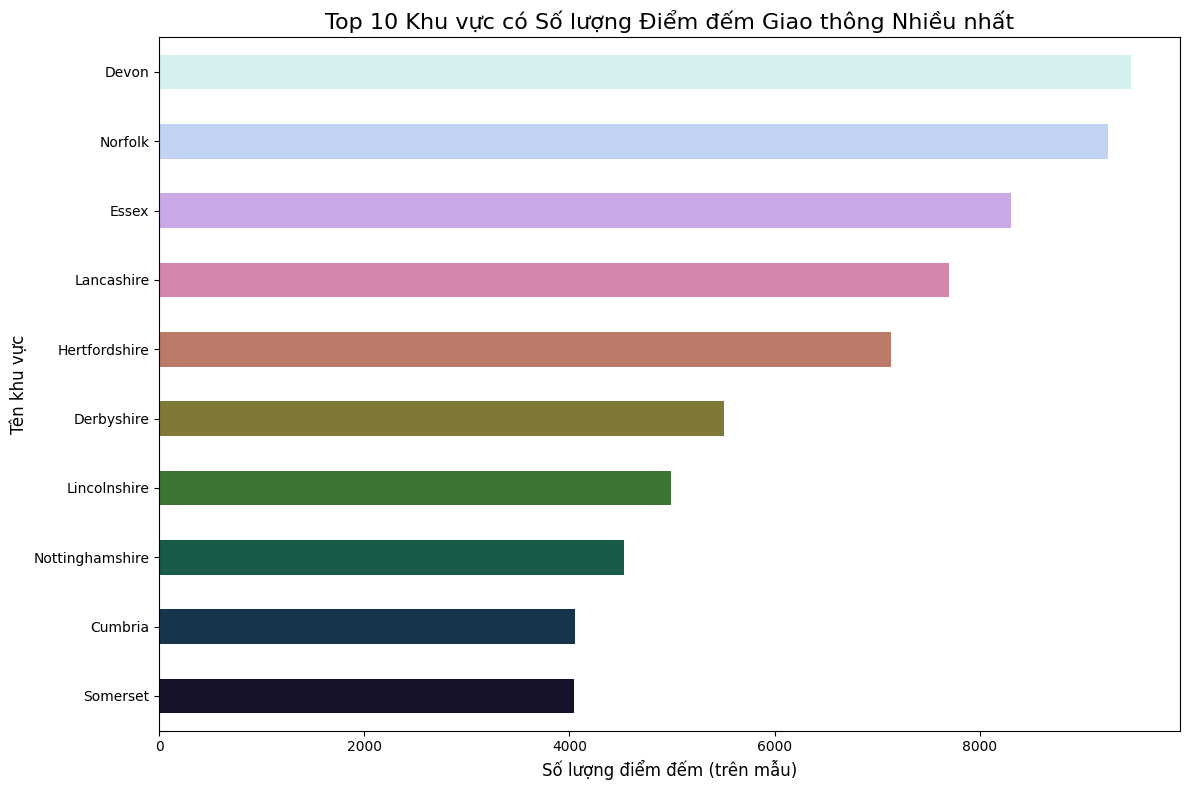

In [12]:
# --- Phân tích 6: Các khu vực trọng điểm ---
print("\n[PHÂN TÍCH 6]: 10 Khu vực trọng điểm (Nhiều điểm đếm nhất)")
print("--------------------------------------------------------------")
# Đếm số lần xuất hiện của mỗi khu vực để xem nơi nào được quan trắc nhiều nhất
top_10_authorities = df['local_authority_name'].value_counts().nlargest(10)
print(top_10_authorities)
# Trực quan hóa
plt.figure(figsize=(12, 8))
top_10_authorities.sort_values(ascending=True).plot(kind='barh', color=sns.color_palette("cubehelix", 10))
plt.title('Top 10 Khu vực có Số lượng Điểm đếm Giao thông Nhiều nhất', fontsize=16)
plt.xlabel('Số lượng điểm đếm (trên mẫu)', fontsize=12)
plt.ylabel('Tên khu vực', fontsize=12)
plt.tight_layout()
plt.savefig('4_top_10_authorities.png')
print("-> Đã lưu biểu đồ vào file '4_top_10_authorities.png'")